#Assignment 5

In [ ]:
!pip install --upgrade tensorflow


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd


In [2]:
# Load your train data
data = pd.read_csv('train.csv')


In [3]:
#load your val data
val_data=pd.read_csv('val.csv')

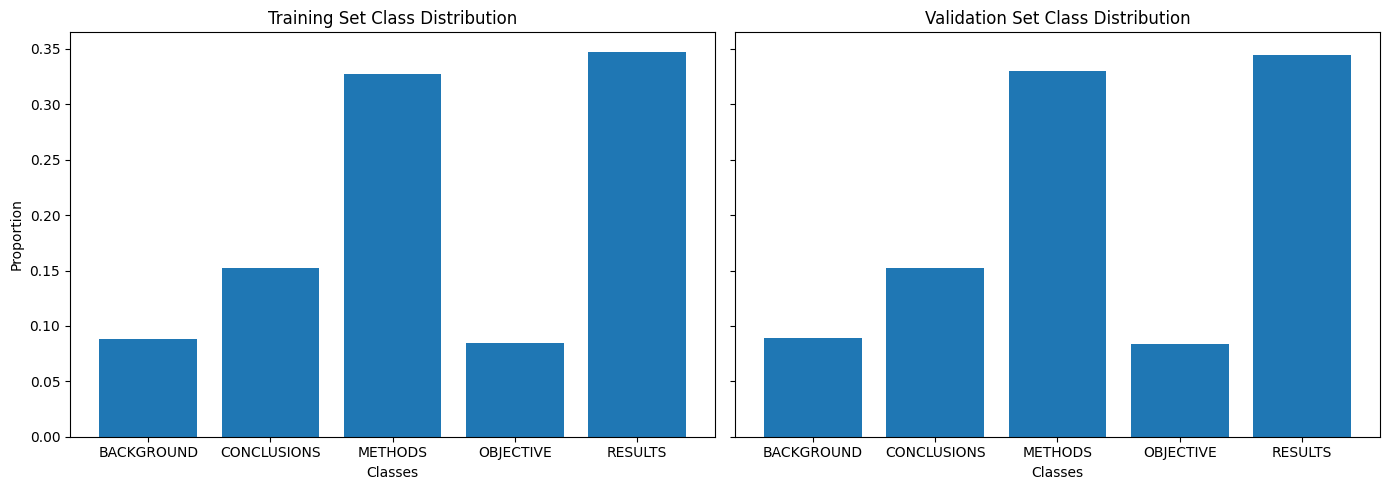

In [7]:
import matplotlib.pyplot as plt
# Load the training and validation datasets
train_data = pd.read_csv('train.csv')
val_data = pd.read_csv('val.csv')

# Preprocess the text for both training and validation data
train_data['cleaned_text'] = train_data['abstract_text'].str.lower()
val_data['cleaned_text'] = val_data['abstract_text'].str.lower()
# Function to plot the class distribution
def plot_class_distribution(train_distribution, val_distribution, class_names):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    # Training class distribution plot
    axes[0].bar(class_names, train_distribution)
    axes[0].set_title('Training Set Class Distribution')
    axes[0].set_ylabel('Proportion')
    axes[0].set_xlabel('Classes')

    # Validation class distribution plot
    axes[1].bar(class_names, val_distribution)
    axes[1].set_title('Validation Set Class Distribution')
    axes[1].set_xlabel('Classes')

    plt.tight_layout()
    plt.show()

# Get class names sorted by index
class_names = train_data['target'].value_counts().index.sort_values()

# Plot the class distribution
plot_class_distribution(
    train_data['target'].value_counts(normalize=True).sort_index(),
    val_data['target'].value_counts(normalize=True).sort_index(),
    class_names
)



1. Load the training and validation datasets from the CSV files.
2. Preprocess both datasets: clean the text, tokenize, and pad the sequences.
Convert the target labels to a format suitable for training (e.g., one-hot encoding).
3. Build the LSTM model (bdirectional LSTM Model with Dropout Layer)
4. Compile the model and print the summary.
5. Train the model using the training data and validate it on the validation data.

In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight


# Load the training and validation datasets
train_data = pd.read_csv('train.csv')
val_data = pd.read_csv('val.csv')

# Preprocess the text for both training and validation data
train_data['cleaned_text'] = train_data['abstract_text'].str.lower()
val_data['cleaned_text'] = val_data['abstract_text'].str.lower()

# Tokenization and Padding Parameters
vocab_size = 60000
max_length = 64
trunc_type = 'post'
padding_type = 'post'     # pad or trunc
oov_tok = "<OOV>"

# Tokenization - Fit only on training data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_data['cleaned_text'])

# Convert training and validation texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['cleaned_text'])
val_sequences = tokenizer.texts_to_sequences(val_data['cleaned_text'])

# Pad the sequences
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Label Encoding using OneHotEncoder for consistency in label dimensions
encoder = OneHotEncoder(sparse=False)
encoder.fit(train_data['target'].values.reshape(-1, 1))  # Fit to get the classes_
train_labels = encoder.transform(train_data['target'].values.reshape(-1, 1))
val_labels = encoder.transform(val_data['target'].values.reshape(-1, 1))

# Building the LSTM Model with a Dropout layer
model = Sequential([
    Embedding(vocab_size, 128, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(train_labels.shape[1], activation='softmax')  # The output layer size based on unique labels
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Calculate class weights
unique_classes = np.unique(train_data['target'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=train_data['target'].values
)

# Since we are working with one-hot encoding, we need to map the weights to the encoded labels.
# First, get the unique classes from the encoder
encoded_classes = encoder.categories_[0]

# Now create the dictionary mapping the index of the class to the computed weight
class_weight_dict = {i: class_weights[np.where(encoded_classes == unique_classes[i])[0][0]] for i in range(len(unique_classes))}

# Use this 'class_weight_dict' when fitting the model
history = model.fit(
    train_padded,
    train_labels,
    epochs=5,
    validation_data=(val_padded, val_labels),
    class_weight=class_weight_dict
)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/5
2500/2500 [==============================] - 60s 21ms/step - loss: 0.8101 - accuracy: 0.7363 - val_loss: 0.5696 - val_accuracy: 0.7957
Epoch 2/5
2500/2500 [==============================] - 36s 14ms/step - loss: 0.5639 - accuracy: 0.8395 - val_loss: 0.5479 - val_accuracy: 0.8056
Epoch 3/5
2500/2500 [==============================] - 36s 14ms/step - loss: 0.4306 - accuracy: 0.8816 - val_loss: 0.6262 - val_accuracy: 0.7811
Epoch 4/5
2500/2500 [==============================] - 35s 14ms/step - loss: 0.3289 - accuracy: 0.9114 - val_loss: 0.7023 - val_accuracy: 0.7887
Epoch 5/5
2500/2500 [==============================] - 35s 14ms/step - loss: 0.2488 - accuracy: 0.9324 - val_loss: 0.7440 - val_accuracy: 0.7817


In [10]:
#save model

model.save('q1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
from google.colab import files
files.download('q1.h5')  # For Google Colab


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
#load model
from tensorflow.keras.models import load_model
model = load_model('q1.h5')


In [16]:
# Load the test dataset
test_data = pd.read_csv('test.csv')

# Preprocess the text for the test data
test_data['cleaned_text'] = test_data['abstract_text'].str.lower()

# Convert test text data to sequences and pad them
test_sequences = tokenizer.texts_to_sequences(test_data['cleaned_text'])
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Encode the test labels
test_labels = encoder.transform(test_data['target'].values.reshape(-1, 1))

# Evaluate the model
loss, accuracy = model.evaluate(test_padded, test_labels)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')


922/922 [==============================] - 2s 2ms/step - loss: 0.6938 - accuracy: 0.7774
Test loss: 0.6937718987464905
Test accuracy: 0.77740478515625


In [17]:
from sklearn.metrics import classification_report

# Predict the classes or probabilities on the test set
test_predictions = model.predict(test_padded)

# If your labels are one-hot encoded, convert predictions and labels back to class integers
test_pred_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

# Generate the classification report
report = classification_report(test_true_classes, test_pred_classes, target_names=encoder.categories_[0])
print(report)


922/922 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

  BACKGROUND       0.50      0.62      0.56      2663
 CONCLUSIONS       0.64      0.76      0.69      4426
     METHODS       0.87      0.87      0.87      9751
   OBJECTIVE       0.66      0.57      0.61      2377
     RESULTS       0.89      0.79      0.84     10276

    accuracy                           0.78     29493
   macro avg       0.71      0.72      0.71     29493
weighted avg       0.79      0.78      0.78     29493



Summary:
I designed a model designed for classification task where the input is a sequence of text that has been tokenized and padded to a fixed length, and the output a probability distribution over possible classes. The bidirectional LSTMs allow the model to capture dependencies in both directions along the input sequnce, hopefully leading to a better performance than a unidirectional LSTM. The dropout layers were added to combat overfitting by randomly dropping out units in the netwrok during changing. Also, I have utilized class weighting to ensure that minority classes 'BACKGROUND' and 'OBJECTIVE' are given appropriate attention during training, even though it is important to note that the class distributions between the training and validation set are nearly identical.

From the results, we can see that the model performs best on the METHODS and RESULTS classies, which could be due to the highest support (more training data). In contrast, the model struggles with the BACKGROUND and OBJECTIVE classes, which might be due to less training data, more complex distinguishing features or less distinctive patterns within these classes. Despite the class distribution being nearly identical between training and validation sets, the varying F1-scores suggests that certain classes may require further model tuning or additional data to improve model generalization.

#Problem 2

In [ ]:
!pip install PySoundFile

In [ ]:
#unzip file
!unzip '/content/edge-collected-gunshot-audio.zip' -d '/content/'



Archive:  /content/edge-collected-gunshot-audio.zip
replace /content/edge-collected-gunshot-audio/38s&ws_dot38_caliber/03fc4685-909e-42c5-aff0-f519f1d14b12_chan0_v0.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Load the CSV file
import librosa
import numpy as np
metadata_csv_path = 'gunshot-audio-labels-only.csv'
metadata_df = pd.read_csv(metadata_csv_path)

# Print out all column names to check their exact format
column_names = metadata_df.columns.tolist()
print("Column names in the CSV file:", column_names)

# Try to match the expected column name with the actual column names, accounting for possible leading/trailing spaces
for name in column_names:
    if 'gunshot_location' in name.lower():
        column_name = name
        break
else:
    raise ValueError("No column contains 'gunshot_location' in its name.")

# Now you have the correct column name
gunshot_locations = metadata_df[column_name]
print(f"Data from column '{column_name}':")
print(gunshot_locations)


Column names in the CSV file: ['filename', ' num_gunshots', ' gunshot_location (in seconds)', ' ', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24']
Data from column ' gunshot_location (in seconds)':
0       0.080998
1       1.720635
2       0.006281
3       0.383537
4       0.110748
          ...   
2143    1.750000
2144    1.590839
2145    1.858821
2146    1.750000
2147    1.750000
Name:  gunshot_location (in seconds), Length: 2148, dtype: float64


In [ ]:
import os
import numpy as np
import librosa
import pandas as pd
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import os
import numpy as np
import librosa
import pandas as pd
import ast
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Helper functions
def extract_uuid(filename):
    return filename.split('_')[0]

def pad2d(a, desired_size):
    rows, cols = a.shape
    padded_a = np.zeros((desired_size, desired_size))
    rows_to_copy = min(rows, desired_size)
    cols_to_copy = min(cols, desired_size)
    padded_a[:rows_to_copy, :cols_to_copy] = a[:rows_to_copy, :cols_to_copy]
    return padded_a

def safe_eval_list(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return []

def concatenate_timestamps(row):
    timestamps = []
    for i in range(2, len(row)):
        if pd.notnull(row[i]):
            if isinstance(row[i], str):
                timestamps.extend(safe_eval_list(row[i]))
            else:
                timestamps.append(row[i])
    return timestamps

# Function to read data and extract features
def read_data(folder_path, metadata_csv_path):
    metadata_df = pd.read_csv(metadata_csv_path, converters={'gunshot_location_in_seconds': safe_eval_list})
    labels = []
    mfccs_list = []

    for label in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, label)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file)
                if file.endswith('.wav'):
                    uuid = extract_uuid(file)
                    row = metadata_df[metadata_df['filename'].str.contains(uuid)].iloc[0]
                    timestamps = concatenate_timestamps(row)

                    y, sr = librosa.load(file_path, sr=22500)
                    for timestamp in timestamps:
                        start_sample = int(timestamp * sr)
                        end_sample = start_sample + int(0.5 * sr)
                        if start_sample < len(y) and end_sample <= len(y):
                            gunshot_segment = y[start_sample:end_sample]
                            mfccs = librosa.feature.mfcc(y=gunshot_segment, sr=sr, n_mfcc=40)
                            padded_mfccs = pad2d(mfccs, 128)
                            mfccs_list.append(padded_mfccs)
                            labels.append(label)

    return np.array(mfccs_list), labels

def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Set the paths for the dataset and the metadata CSV
folder_path = 'edge-collected-gunshot-audio'
labels_csv_path ='gunshot-audio-labels-only.csv'

# Read the data and labels
mfccs, labels = read_data(folder_path, labels_csv_path)

if not labels:
    raise ValueError("Label array is empty. Ensure that the 'labels' list is being populated correctly.")

# Preprocess the data
desired_size = 128
mfccs = np.array([pad2d(m, desired_size) for m in mfccs])
mfccs = np.expand_dims(mfccs, axis=-1)

# Verify labels are not empty
if not labels:
    raise ValueError("Label array is empty. Ensure that the 'labels' list is being populated correctly.")

# Verify that labels are correctly mapped to indices
label_dict = {label: idx for idx, label in enumerate(sorted(set(labels)))}
print("Label dictionary:", label_dict)

# Convert labels to indices using the label dictionary
y_indices = [label_dict[label] for label in labels]

# Verify that y_indices is not empty
if not y_indices:
    raise ValueError("y_indices array is empty. Ensure that labels are mapped to indices correctly.")

# Now convert label indices to one-hot encoded labels
y = to_categorical(y_indices)

# Verify that y is not empty and has the correct shape
if y.size == 0 or y.shape[1] <= 1:
    raise ValueError(f"Problem with one-hot encoding. Check y: {y}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(mfccs, y, test_size=0.2, random_state=42)

# Define the input shape and number of classes
input_shape = X_train[0].shape
num_classes = y.shape[1]

# Create and compile the model
model = create_cnn_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

# Save the model
model.save('gunshot_classification_model')


Label dictionary: {'38s&ws_dot38_caliber': 0, 'glock_17_9mm_caliber': 1, 'remington_870_12_gauge': 2, 'ruger_ar_556_dot223_caliber': 3}
Epoch 1/100
145/145 [==============================] - 4s 13ms/step - loss: 1.5318 - accuracy: 0.4280 - val_loss: 1.2734 - val_accuracy: 0.4519
Epoch 2/100
145/145 [==============================] - 1s 10ms/step - loss: 1.1869 - accuracy: 0.4529 - val_loss: 1.1050 - val_accuracy: 0.4432
Epoch 3/100
145/145 [==============================] - 1s 10ms/step - loss: 1.1537 - accuracy: 0.4512 - val_loss: 2.8069 - val_accuracy: 0.2350
Epoch 4/100
145/145 [==============================] - 1s 10ms/step - loss: 1.1342 - accuracy: 0.4512 - val_loss: 5.8683 - val_accuracy: 0.2350
Epoch 5/100
145/145 [==============================] - 1s 10ms/step - loss: 1.1487 - accuracy: 0.4488 - val_loss: 2.9087 - val_accuracy: 0.3738
Epoch 6/100
145/145 [==============================] - 1s 10ms/step - loss: 1.1164 - accuracy: 0.4512 - val_loss: 1.0170 - val_accuracy: 0.4432


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Load the saved model
model = load_model('gunshot_classification_model')

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Calculate precision, recall, and F1-score
report = classification_report(y_true_classes, y_pred_classes)

print("Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)


37/37 [==============================] - 0s 3ms/step
Model Evaluation Metrics:
Accuracy: 0.9609713790112749

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       222
           1       0.92      0.98      0.95       257
           2       1.00      0.85      0.92       163
           3       0.96      0.98      0.97       511

    accuracy                           0.96      1153
   macro avg       0.97      0.95      0.96      1153
weighted avg       0.96      0.96      0.96      1153



Summary:


For the Classification report we have that
'0'='ruger_ar_556_dot223_caliber'
'1'='remington_870_12_gauge'
'2'='glock_17_9mm_caliber'
'3'='38s&ws_dot38_caliber'

For the preprocesing step as we are processing the audiofiles we extract the Mel-frequency cepstral coefficients (MFCCs). These features are then padded to a uniform size for input into the CNN, and labels are converted from string format to one-hot encoded vectors. The CNN used includes multiple convolution layers with ReLU activation, max-pooling layers, batch normalization, a flattening layer, a dense layer, dropout for regularization, and a softmax output layer for classification. We split the data into testing and training sets. Next the CNN model is instantiated and compiled with the Adam optimized and categorical cross-entropy function, and trained with the training data.

Upon evaluating the CNN model with the testing data, the classification report revealed high performance across the board. THe model achieved an accuracy of approximately 0.97, with precision, recall and F1-scores reflective of a robust ability to classify audio samples correctly. Particularly, the odel demonstrated perfect precision for class '2'='glock_17_9mm_caliber', indicating no false positive for this category. The recall was highest for '3'='38s&ws_dot38_caliber', suggesting that nearly all actual positives were correctly identified for this class. The macro and weighted averages for precision recall, and F1-score were consistent, at about 0.96 indicating a balanced performance across all classes and considering class support.

#Extra Credit #1

Title:Measurements Analysis Classification, Detection of Gunshot and Gunshot like Sounds

Author:Rajesh Baliram Singh, Hanqi Zhuang

Research Question:
The paper investigates the efficacy of using Random Forest classifiers within a machine learning model to detect gunshots acoustically, distinguishing them from nine other similar acoustic events.

Methodology:
The study standardizes a diverse dataset of ten audio classes to uniform 1-second clips and employs MFCCs for feature extraction, with a detailed preprocessing pipeline that includes windowing, Fourier transform, power spectrum computation, application of the Mel scale, and finally obtaining the MFCCs. The Random Forest Classifier is then trained on subsets of this data, utilizing multiple decision trees and majority voting for classification.

Key Findings:
The research concludes that Random Forest classifiers can accurately classify audio events, with feature importance evaluated using methods like MDI and SHAP to assess the contribution of each feature to the model's predictions, thereby enhancing the understanding and interpretability of the model's decision-making process.

#Extra Credit #2:

Title: Towards an Indoor Gunshot Detection and Notification System Using Deep Learning

Author: Tareq Khan

Research Question:
The paper investigates the feasibility of using a deep learning-based CNN to detect indoor gunshot sounds from audio samples, focusing on the system's ability to differentiate gunshots from non-gunshot ambient noise.

Methodology:
The methodology involves training a CNN on 670,000 processed and augmented audio samples using MFCCs for feature extraction, followed by a validation phase for hyperparameter tuning and a testing phase on a separate dataset to ascertain the model's accuracy and efficiency.

Key Findings:
The key findings reveal that the CNN model achieves a 98% accuracy rate in identifying gunshot sounds and is effectively optimized for real-time audio analysis on the NVIDIA Jetson Nano, highlighting the system's precision and deployment readiness.


#Extra Credit #3:

Title: Machine Learning Inspired Efficient Acoustic Gunshot Detection and Localization System

Authors:Muhammad Salman Kabira, Junaid Mira, Caleb Rasconb,
Muhammad Laiq Ur Rahman Shahida, Furqan Shaukata



Research Question:
The article explores a machine learning system aimed at real-time detection and localization of gunshots to improve public safety responses, focusing on identifying the occurrence rather than the type of gunfire.

Methodology:
The approach utilizes acoustic feature extraction techniques like MFCC, GTCC, LPC, and spectral centroid, and implements machine learning classifiers such as bagged tree ensembles and support vector machines to recognize and localize gunshot sounds.

Key Findings:
The system successfully detects the presence of gunshots and locates their origin, prioritizing immediate recognition over firearm type differentiation, which is instrumental for rapid response in public safety applications.

#Extra Credit #4:


Title: Gun identification from gunshot audios for secure public places using transformer learning

Authors: Rahul Nijhawan, SharikAliAnsari, Sunil Kumar, FawazAlassery,
Sayed M. El‑kenawy

 Research Question:
The paper addresses the challenge of identifying the type of firearm used in a gunshot event based on the audio signature of the gunshot, aiming to classify sounds into categories such as rifle, handgun, or non-gunshot.

Methodology:
The research employs Mel-frequency cepstral coefficients (MFCCs) to characterize audio features and explores the effectiveness of convolutional neural networks (CNNs) versus transformer-based architectures in classifying 1-second audio clips of gunshots, which were uniformly standardized in the preprocessing phase.

Key Findings:
The study finds that transformer-based models, due to their ability to contextualize the entire audio clip, show promise in distinguishing between subtle differences in gunshot sounds, potentially outperforming traditional CNNs that focus on local sound features.

#Extra Credit #5:

Title: Alignment Based Matching Networks For One-Shot Classification and Open-Set Recognition

Author: Paresh Malalur, Tommi Jaakkola

Research Question: The paper addresses the problem of one-shot classification and open-set recognition, focusing on how to effectively perform these tasks with minimal examples and ensuring the model remains interpretable.

Methodology: The researchers propose Alignment-Based Matching Networks (ABM Nets), which utilize a two-tier matching model that first aligns images via learned contextual point matching and then uses this alignment to aid in classification. The methodology involves self-regularization for training and a novel approach to learn explicit alignments between images for improved interpretability and performance.

Key Findings: ABM Nets achieved state-of-the-art performance on one-shot learning tasks and outperformed existing models in one-shot open-set recognition by maintaining high accuracy and F1 scores. The paper also shows that ABM Nets provide insights into the model's decision-making by analyzing point match likelihoods, which helps in understanding the semantic information captured by the network.